<a href="https://colab.research.google.com/github/EcoLabBET/ExOrChiST/blob/main/Examples/Trend_Analysis_with_pink-noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

# Install RangeShifts and PyPDF2
!pip install git+https://github.com/EcoLabBET/RangeShifts.git
!pip install PyPDF2

import RangeShifts.PinkNoise as pn
from RangeShifts.logging import mc_logger
from PyPDF2 import PdfMerger

  Cloning https://github.com/EcoLabBET/RangeShifts.git to /tmp/pip-req-build-k_d1v6nn
  Running command git clone --filter=blob:none --quiet https://github.com/EcoLabBET/RangeShifts.git /tmp/pip-req-build-k_d1v6nn
  Resolved https://github.com/EcoLabBET/RangeShifts.git to commit 3542f368b5389b06766524814913bbd5a581ec60
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.7 MB/s eta 0:00:00
  Created wheel for RangeShifts: filename=RangeShifts-0.1-py3-none-any.whl size=25144 sha256=037c5129794c1aa9d7ad6f0b3810997f13ad4290e9e58d57710c913e8c02ac11
  Stored in directory: /tmp/pip-ephem-wheel-cache-ula046zj/wheels/4c/39/58/2abe5c9dec12ab4fc491b1c79acb7900dea2107d7fece29708
Successfully built RangeShifts
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.5 MB/s eta 0:00:00


## 0.Produce Synthetic Data

In [2]:
# Parameters
np.random.seed(432)        # for reproducibility
num_series = 25           # Number of species
series_length = 4         # Number of time periods
grid_size = 2500          # Total number of cells
year_range = (1960, 2020) # Range of Observation

# Generate time periods
time_periods = sorted([year_range[0], year_range[1]] +
                     np.random.choice(np.arange(year_range[0] + 1, year_range[1]),
                                     size=series_length - 2,
                                     replace=False).tolist())

data = {'time_periods': time_periods}

for i in range(1, num_series + 1):
    # Calculate starting population (5-70% of grid)
    start = np.random.uniform(0.05, 0.7) * grid_size

    # Random trend (-20 to +20 per time step)
    trend = np.random.randint(-20, 20)

    # Generate counts with small noise (±20% of start)
    counts = [int(np.clip(start + trend*t + np.random.normal(0, 0.2*start), 1, grid_size))
              for t in range(series_length)]

    data[f'species_{i}'] = counts

df_input = pd.DataFrame(data)
df_input.to_csv('Sum_of_Occurences_Synthetic_data.csv', index=False)

In [3]:
df_input

,time_periods,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,...,species_16,species_17,species_18,species_19,species_20,species_21,species_22,species_23,species_24,species_25
0,1960,1580,534,855,322,700,1439,266,169,371,...,437,1561,1185,1004,1752,782,1173,1183,405,761
1,1974,1330,489,884,257,781,1181,259,167,652,...,307,1287,813,1225,1799,656,609,1309,624,883
2,2008,1890,425,667,323,819,1843,254,154,534,...,420,1691,1220,593,1835,773,572,1181,631,891
3,2020,1597,330,883,204,893,1113,318,137,484,...,340,1404,1366,1021,1643,819,1117,913,541,882


## 1.Use RangeShifts to calculate the p-values

In [4]:

mc_reps = 10**3 # Reduced for a quicker example

# Initialise a dataframe to store the calculated fits
columns = ['species','slope','intercept','MC_white(p-val)','MC_pink(p-val)','fit_white(p-val)']
df_results = pd.DataFrame(columns=columns)

for sp in df_input.drop(columns=['time_periods']).columns:
  xy_array = df_input[['time_periods',sp]].transpose().values
  tmax = int(xy_array[0][-1]-xy_array[0][0]) + 1

  MC_white = pn.MonteCarlo_significance(xy_array,MC_reps=mc_reps,
                                        noise_func= pn.noise_white,
                                        noise_kwargs = {'tmax':tmax},
                                        log_kwargs = {'name':f'{sp}-synth'})

  MC_pink = pn.MonteCarlo_significance(xy_array,MC_reps=mc_reps,
                                        noise_func= pn.noise_pink,
                                        noise_kwargs = {'nu':1,'beta':2,'tmax':tmax},
                                        log_kwargs = {'name':f'{sp}-synth'})

  fit_white = pn.white_fit_significance(xy_array)

  # Append to the df
  values = [sp, MC_white[1], MC_white[2],MC_white[0], MC_pink[0],fit_white]
  df_results.loc[len(df_results)] = values

In [5]:
df_results.to_csv('Synthetic_Results.csv', index=False)
df_results

,species,slope,intercept,MC_white(p-val),MC_pink(p-val),fit_white(p-val)
0,species_1,4.225095,-6810.800757,0.2410,0.2840,0.240288
1,species_2,-3.019336,6454.488020,0.0250,0.0260,0.019470
2,species_3,-1.236864,3284.228247,0.3310,0.3565,0.333138
3,species_4,-1.005044,2277.040353,0.2565,0.2860,0.253274
4,species_5,2.706810,-4589.654477,0.0320,0.0420,0.025555
5,species_6,0.718789,-36.750315,0.4690,0.4760,0.469390
6,species_7,0.605086,-930.174023,0.2205,0.2560,0.211968
7,species_8,-0.493274,1138.612863,0.0290,0.0395,0.029150
8,species_9,0.651324,-786.210593,0.4225,0.4335,0.421301
9,species_10,-1.373476,3739.654477,0.3135,0.3565,0.314822


## 2.Generate the distribution graphs of the p-values

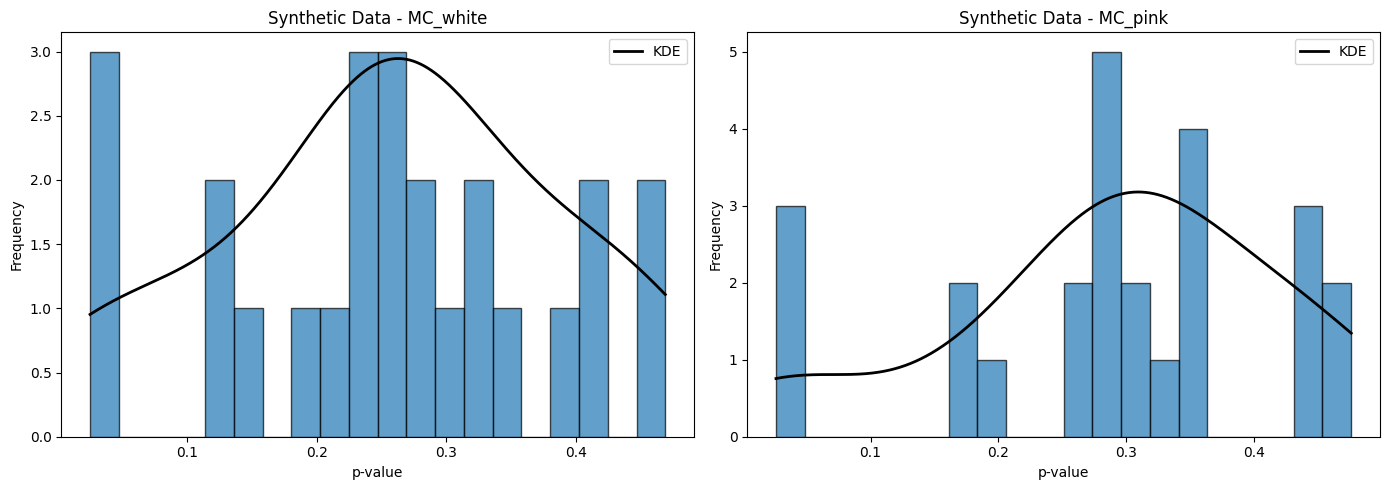

In [6]:
from scipy.stats import gaussian_kde

def plot_hist_with_kde(ax, data, title, x_label):
    # Plot histogram
    ax.hist(data, bins=20, edgecolor='black', density=False, alpha=0.7)

    # Compute and plot KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    ax.plot(x_vals, kde(x_vals), color='black', linewidth=2, label='KDE')

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Frequency')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_hist_with_kde(ax=ax1, data=df_results['MC_white(p-val)'].to_numpy(),
                   title='Synthetic Data - MC_white', x_label='p-value')
plot_hist_with_kde(ax=ax2, data=df_results['MC_pink(p-val)'].to_numpy(),
                   title='Synthetic Data - MC_pink', x_label='p-value')

plt.tight_layout()
plt.savefig('Synthetic_Histograms_with_KDE.pdf')
plt.show()

## 3.Generate Summary table

In [8]:
# 4. Generate a table
def make_table(df,p_val):
  """
  Simple Wrapper that allows to create a table similar
  to the one required for the publication.
    df: dataframe as exported from previous sessions
    p_val:p_value
  """
  def count_sub(df,column,p_val):
      # Calculate total length of DataFrame
      total_length = len(df)

      # Filter dataframe for conditions and calculate percentages simultaneously
      a = len(df[(df[column] < p_val) & (df['slope'] > 0)]) / total_length * 100
      c = len(df[(df[column] < p_val) & (df['slope'] < 0)]) / total_length * 100
      b = len(df[df[column] >= p_val]) / total_length * 100

      return [a,b,c]

  # Calculate Values
  x1,_,x3 = count_sub(df,'MC_white(p-val)',p_val=1) # Essentially we only filter for slope
  y1,y2,y3 = count_sub(df,'MC_white(p-val)',p_val=p_val)
  z1,z2,z3 = count_sub(df,'MC_pink(p-val)',p_val=p_val)

  # Create a DataFrame with the 'Trend significance' column as the index
  table = {
      'Increasing': [f"{x1:.2f}%",f"{y1:.2f}%",f"{z1:.2f}%"],
      'Non-significant trend': ['-',f"{y2:.2f}%",f"{z2:.2f}%"],
      'Decreasing': [f"{x3:.2f}%",f"{y3:.2f}%",f"{z3:.2f}%"]
  }
  index = ['On basis of sign',f'p-value < {int(p_val*100)} %',f'p-value < {int(p_val*100)} % (1/f-noise)']
  table_df = pd.DataFrame(table,index=index)
  table_df.columns.name = 'Trend significance'

  return table_df



In [9]:
p_val = 0.05

results_table = make_table(df_results, p_val)
print(f"\nResults Table [p-cuttoff:{p_val}]:")
display(results_table)


Results Table [p-cuttoff:0.05]:


Trend significance,Increasing,Non-significant trend,Decreasing
On basis of sign,52.00%,-,48.00%
p-value < 5 %,4.00%,88.00%,8.00%
p-value < 5 % (1/f-noise),4.00%,88.00%,8.00%


## 4.Produce a pdf for the convergence of the MC algorithm using the logging

In [10]:
mc_logger.plot_output_logs()


**Analysis complete. Check the following files in your /content/ directory:**
- **/content/Sum_of_Occurences_Synthetic_data.csv** : input data
- **/content/Synthetic_Results.csv** : fits and p-values


- **/content/Synthetic_Histograms_with_KDE.pdf** : p-val distribution


- **/content/mc_log.json** : logging file of the MC algorithms
- **/content/output_logs.pdf** : logging export <font color=orange>(increase mc_reps for convergence)</font>